# Entropic Regularization of Optimal Transport

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gpeyre/ot4ml/blob/main/python/2-sinkhorn.ipynb)

In [2]:
using Random
using SparseArrays
using LinearAlgebra
using Plots

In [3]:
# Helper function so match the `imshow` function from Python
function imshow!(plt, data, title="")
    heatmap!(
        plt,
        data,
        aspect_ratio=:equal,
        colorbar=false,
        yflip=true,
        title=title,
        axis=false
    )
end

imshow! (generic function with 2 methods)

This numerical tours exposes the general methodology of regularizing the
optimal transport (OT) linear program using entropy. This allows to
derive fast computation algorithm based on iterative projections
according to a Kulback-Leiber divergence.

Entropic Regularization of Optimal Transport
--------------------------------------------
We consider two input histograms $a, b \in \Sigma_n$, where the probability simplex in $\mathbb{R}^n$ is defined as
$$
\Sigma_n := \left\{ a \in \mathbb{R}_+^n \;\middle|\; \sum_{i=1}^n a_i = 1 \right\}.
$$

We define the discrete entropic regularized transport cost as
$$
W_\epsilon(a, b) := \min_{P \in U(a, b)} \sum_{i,j} C_{i,j} P_{i,j} - \epsilon E(P),
$$
where the polytope of couplings is given by
$$
U(a, b) := \left\{ P \in \left(\mathbb{R}_+\right)^{n \times m} \;\middle|\; P \mathbf{1}_m = a,\; P^\top \mathbf{1}_n = b \right\},
$$
with $\mathbf{1}_n := (1, \ldots, 1)^\top \in \mathbb{R}^n$.

For $P \in \mathbb{R}_+^{n \times m}$, the entropy is defined as
$$
E(P) := -\sum_{i,j} P_{i,j} \left( \log(P_{i,j}) - 1 \right).
$$

When $\epsilon = 0$, one recovers the classical (discrete) optimal transport cost.

The matrix $C \in \left(\mathbb{R}_+\right)^{n \times m}$ defines the ground cost, where $C_{i,j}$ is the cost of transporting mass from bin $i$ to bin $j$.

The regularized transport problem can be rewritten as a projection:
$$
W_\epsilon(a, b) = \epsilon \min_{P \in U(a, b)} \mathrm{KL}(P \,\|\, K),
$$
where the Gibbs kernel $K$ is defined as
$$
K_{i,j} := \exp\left( -\frac{C_{i,j}}{\epsilon} \right),
$$
and the Kullback-Leibler divergence between $P, K \in \mathbb{R}_+^{n \times m}$ is given by
$$
\mathrm{KL}(P \,\|\, K) := \sum_{i,j} P_{i,j} \left( \log\left( \frac{P_{i,j}}{K_{i,j}} \right) - 1 \right).
$$

Given a convex set $\mathcal{C} \subset \mathbb{R}^N$, the projection of $\xi$ onto $\mathcal{C}$ with respect to the Kullback-Leibler divergence is defined as
$$
\mathrm{Proj}_{\mathcal{C}}^{\mathrm{KL}}(\xi) := \underset{\pi \in \mathcal{C}}{\arg\min} \, \mathrm{KL}(\pi \,\|\, \xi).
$$

Iterative Bregman Projection Algorithm
--------------------------------------

Given two affine constraint sets $\mathcal{C}_1$ and $\mathcal{C}_2$, we aim to compute the projection
$$
\mathrm{Proj}_{\mathcal{C}}^{\mathrm{KL}}(K), \quad \text{where} \quad \mathcal{C} = \mathcal{C}_1 \cap \mathcal{C}_2.
$$
(This description naturally extends to intersections involving more than two sets.)

This projection can be computed iteratively, starting from $P_0 = K$, by applying alternating projections:
$$
P_{2\ell+1} = \mathrm{Proj}_{\mathcal{C}_1}^{\mathrm{KL}}(P_{2\ell}), \quad
P_{2\ell+2} = \mathrm{Proj}_{\mathcal{C}_2}^{\mathrm{KL}}(P_{2\ell+1}) \quad \text{for all } \ell \geq 0.
$$

One can show that the sequence $(P_\ell)$ converges to the desired projection:
$$
P_\ell \rightarrow \mathrm{Proj}_{\mathcal{C}}^{\mathrm{KL}}(K).
$$

Sinkhorn's Algorithm
-----------------------------------------------------------------------

A fundamental observation is that the optimality condition of the entropic regularized transport problem implies that the optimal coupling $P_\epsilon$ necessarily has the form
$$
P_\epsilon = \operatorname{diag}(u) \, K \, \operatorname{diag}(v),
$$
where the Gibbs kernel is defined as
$$
K := \exp\left( -\frac{C}{\epsilon} \right).
$$

To satisfy the marginal constraints, one must find two positive scaling vectors $u \in \mathbb{R}_+^n$ and $v \in \mathbb{R}_+^m$ such that the following equalities hold:
$$
P \mathbf{1}_m = u \odot (K v) = a, \quad \text{and} \quad
P^\top \mathbf{1}_n = v \odot (K^\top u) = b,
$$
where $\odot$ denotes element-wise (Hadamard) multiplication.

Sinkhorn's algorithm alternates between updates of these two equations and proceeds as follows:
$$
u \leftarrow \frac{a}{K v}, \quad
v \leftarrow \frac{b}{K^\top u},
$$
where the divisions are element-wise.

Transport Between Point Clouds
------------------------------
We first test the method for two input measures that are uniform measures
(i.e. constant histograms) supported on two point clouds
(that do not necessarily have the same size).


We thus first load two points clouds $x=(x_i)_{i=1}^{n}, y=(y_i)_{i=1}^{m}, $
where $x_i, y_i \in \mathbb{R}^2$.


Number of points in each cloud, $N=(n,m)$.

In [4]:
N = [300,200];

Dimension of the clouds.

In [5]:
d = 2;

Point cloud $x$, of $n$ points inside a square.

In [6]:
x = rand(2, N[1]) .- .5;

Point cloud $y$, of $m$ points inside an anulus.

In [7]:
theta = 2*pi*rand(1, N[2])
r = .8 .+ .2 .* rand(1, N[2])
y = vcat(cos.(theta) .* r, sin.(theta) .* r);

Shortcut for displaying point clouds.

In [8]:
function plotp!(plt, x, col)
    scatter!(
        plt,
        x[1,:],
        x[2,:],
        markersize=10,
        markercolor=col,
        markerstrokewidth=2,
        legend=false
    )
end

plotp! (generic function with 1 method)

Display of the two clouds.

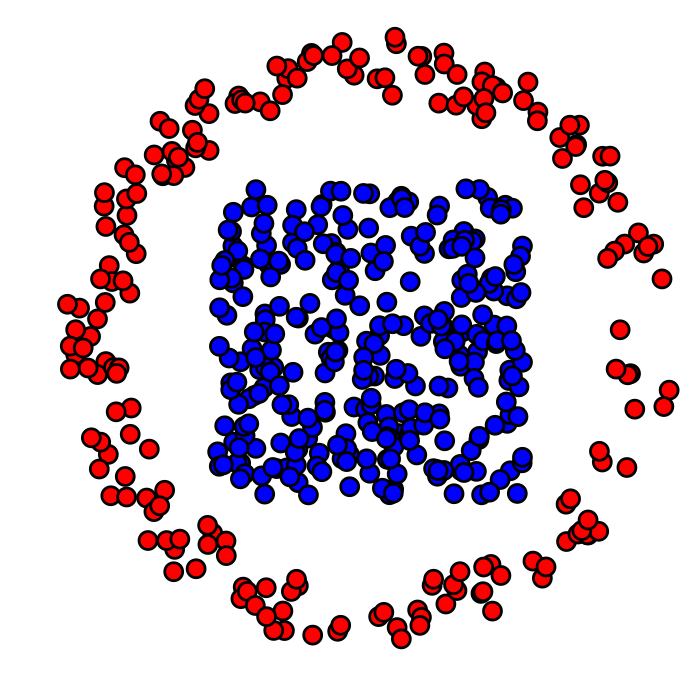

In [11]:
plt = plot(size=(700, 700), aspect_ratio=:equal, border=:none)
plotp!(plt, x, :blue)
plotp!(plt, y, :red)

The cost matrix is defined as
$$
C_{i,j} = \|x_i - y_j\|^2,
$$
where $\|\cdot\|$ denotes the Euclidean norm in $\mathbb{R}^d$.

In [12]:
x2 = sum(abs2, x, dims=1)
y2 = sum(abs2, y, dims=1)
C = x2' .+ y2 .- 2 .* x' * y;

Target histograms $(a,b)$, here uniform histograms.

In [13]:
a = ones(N[1])/N[1]
b = ones(N[2])/N[2];

Regularization strength $\epsilon>0$.

In [14]:
epsilon = .01;

Gibbs Kernel $K$.

In [15]:
K = exp.(-C ./ epsilon);

The algorithm is typically initialized with
$$
v = \mathbf{1}_m,
$$
where $\mathbf{1}_m$ is the vector of all ones in $\mathbb{R}^m$.  
The vector $u$ does not need to be explicitly initialized, as it is computed in the first iteration.

In [16]:
v = ones(N[2]);

One sinkhorn iterations.

In [17]:
u = a ./ (K * v)
v = b ./ (K' * u);

We now implement the Sinkhorn algorithm.

To monitor convergence, we display the evolution of the constraint satisfaction errors:
$$
\|P \mathbf{1}_m - a\|_1 \quad \text{and} \quad \|P^\top \mathbf{1}_n - b\|_1,
$$
where \( $P = \operatorname{diag}(u) K \operatorname{diag}(v)$ \).  
Note that these residuals can be computed directly from the scaling vectors \( (u, v) \) as:
$$
P \mathbf{1}_m = u \odot (K v), \quad
P^\top \mathbf{1}_n = v \odot (K^\top u).
$$

We display the violations of these marginal constraints over iterations using a logarithmic scale (log-plot).

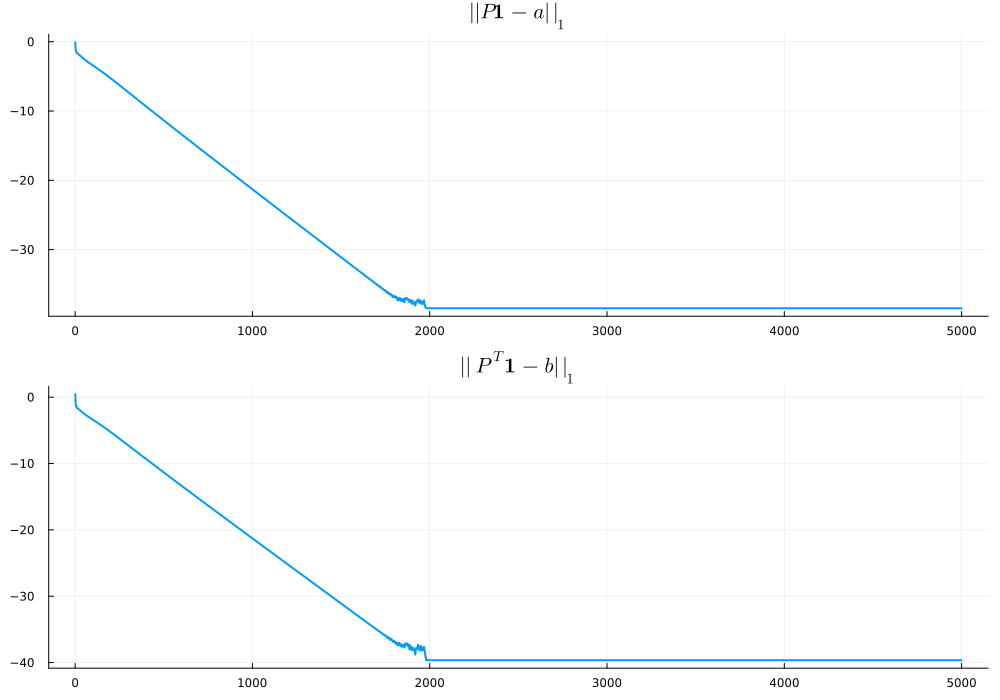

In [18]:
function compute_sinkhorn(N, niter, K, a, b)
    v = ones(N)
    u = ones(N)
    Err_p = Float64[]
    Err_q = Float64[]

    for _ in 1:niter
        # Sinkhorn step 1
        u = a ./ (K * v)
        # error computation
        r = v .* (K' * u)
        push!(Err_q, norm(r - b, 1))
        # Sinkhorn step 2
        v = b ./ (K' * u)
        s = u .* (K * v)
        push!(Err_p, norm(s - a, 1))
    end

    plt = plot(layout=(2, 1), size=(1000, 700))
    plot!(plt[1], log.(Err_p), linewidth=2, title="\$||P \\mathbf{1} - a||_1\$", label=nothing)
    plot!(plt[2], log.(Err_q), linewidth=2, title="\$||P^T \\mathbf{1} - b||_1\$", label=nothing)

    return plt, u, v
end

epsilon = 0.01
K = exp.(-C ./ epsilon)

plt, u, v = compute_sinkhorn(N[2], 5000, K, a, b)
display(plt)

Compute the final matrix $P$.

In [19]:
P = diagm(u) * K * diagm(v);

Display it.

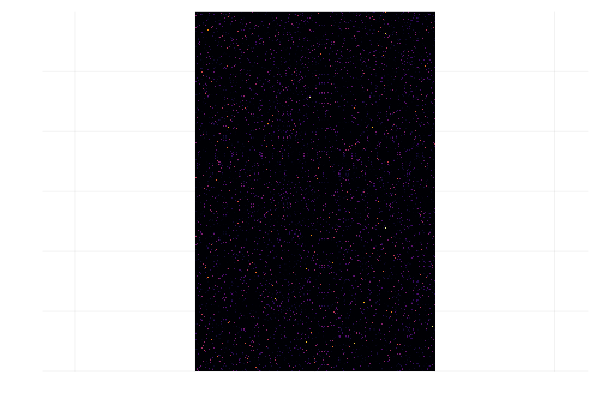

In [20]:
plt = plot()
imshow!(plt, P)
display(plt)

We now display the regularized transport solution for various values of $\epsilon$.

As $\epsilon$ decreases, the solution becomes increasingly sparse and concentrates around the minimal-cost entries. For very small values of $\epsilon$, we observe that:

- The coupling matrix \( $P_\epsilon$ \) approaches a sparse solution, often close to a permutation matrix when the marginals are uniform and balanced.
- Numerical instabilities may occur due to very small entries in the kernel \( $K = \exp(-C / \epsilon)$ \), which can lead to underflow and convergence issues in Sinkhorn's algorithm.
- The convergence of the algorithm becomes slower, and more iterations may be needed to meet a given tolerance.

This behavior highlights a trade-off: small $\epsilon$ values approximate the true (unregularized) optimal transport solution more closely, but they also introduce computational and numerical challenges.

For very small values of $\epsilon$, numerical instabilities can arise: the entries of the kernel
$$
K = \exp\left(-\frac{C}{\epsilon}\right)
$$
may underflow to zero, causing divisions by zero or producing `NaN` values during the Sinkhorn iterations.

As a result, the algorithm may break down, and the iterates $(u, v)$ can become undefined (`NaN`).

To address this issue, one must use a numerically stable implementation of Sinkhorn's algorithm based on a log-domain formulation, leveraging the log-sum-exp trick.

This approach is detailed in the next notebook on *Advanced Sinkhorn*, which provides a stable algorithm suitable for small values of $\epsilon$.


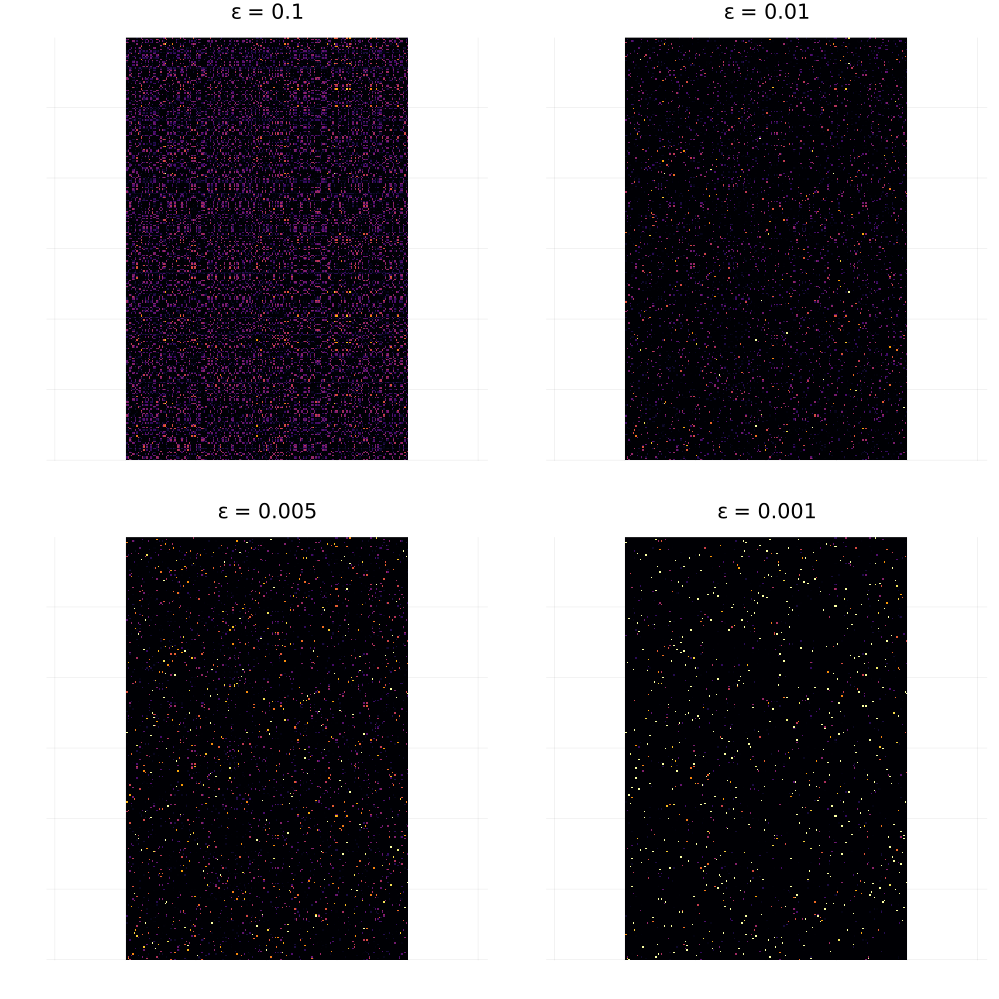

In [21]:
plt = plot(layout=(2, 2), size=(1000, 1000))
glist = [0.1, 0.01, 0.005, 0.001]
niter = 300

for (k, epsilon) in enumerate(glist)
    K = exp.(-C ./ epsilon)
    v = ones(N[2])

    for i in 1:niter
        u = a ./ (K * v)
        v = b ./ (K' * u)
    end

    P = diagm(u) * K * diagm(v)
    imshow!(plt[k], clamp.(P, 0, minimum(1 ./ N) * 0.3), "\\epsilon = $(epsilon)")
end

display(plt)

Compute the obtained optimal $P$.

In [22]:
P = diagm(u) * K * diagm(v);

Keep only the highest entries of the coupling matrix, and use them to
draw a map between the two clouds.
First we draw "strong" connexions, i.e. linkds $(i,j)$ corresponding to
large values of $P_{i,j}$.
We then draw weaker connexions.

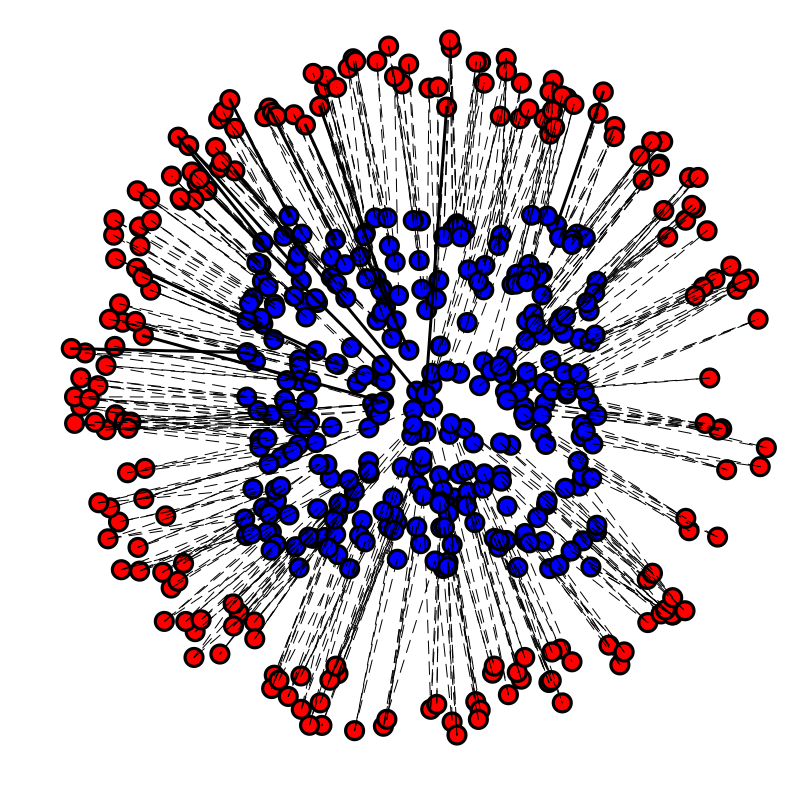

In [23]:
plt = plot(size=(800, 800), aspect_ratio=:equal, border=:none, axis=false)

plotp!(plt, x, :blue)
plotp!(plt, y, :red)

# Display the stronger connections with solid lines and weaker with dashed lines
for (thresh, ls, lw) in zip([0.8, 0.2], [:solid, :dash], [3, 1])
    A = P .* (P .> maximum(P) * thresh)
    I, J = findnz(sparse(A))

    for k in eachindex(I)
        row = I[k]
        col = J[k]
        plot!(
            plt,
            [x[1, row], y[1, col]],
            [x[2, row], y[2, col]],
            lc=:black,
            lw=lw,
            ls=ls,
            legend=false
        )
    end
end

display(plt)

Transport Between Histograms
----------------------------
We now consider a different setup, where the histogram values
$a,b$ are not uniform, but the measures are defined on a uniform grid
$x_i=y_i=i/n$. They are thue often refered to as "histograms".


Size $n$ of the histograms.

In [24]:
N = 200;

We use here a 1-D square Euclidean metric.

In [25]:
t = (0:N-1)/N;

Define the histogram $a,b$ as translated Gaussians.

In [26]:
Gaussian(t0,sigma) = exp.(-(t .- t0).^2 ./ (2 * sigma^2))
mynormalize(p) = p ./ sum(p)
sigma = .06
a = Gaussian(.25, sigma)
b = Gaussian(.8, sigma);

Add some minimal mass and normalize.

In [27]:
vmin = .02;
a = mynormalize(a .+ maximum(a)*vmin)
b = mynormalize(b .+ maximum(b)*vmin);

Display the histograms.

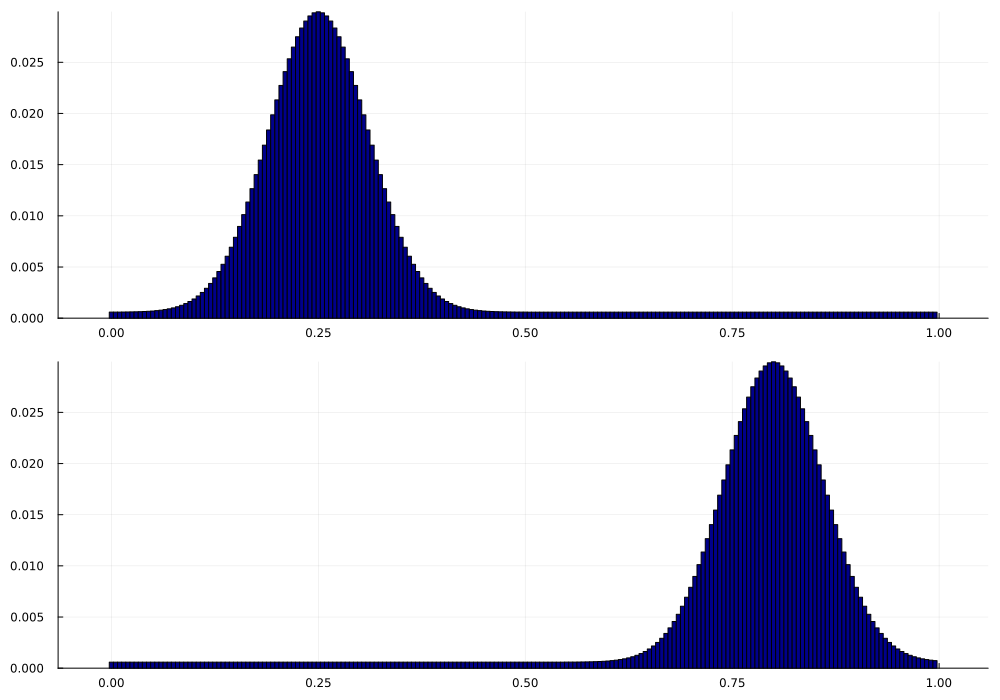

In [28]:
plt = plot(layout=(2, 1), size=(1000, 700))
bar!(plt[1], t, a, bar_width=1/length(t), color=:darkblue, legend=false)
bar!(plt[2], t, b, bar_width=1/length(t), color=:darkblue, legend=false)
display(plt)

Regularization strength $\gamma$.

In [29]:
epsilon = (.03)^2;

The Gibbs kernel is a Gaussian convolution,
$$ K_{i,j} := e^{ -(i/N-j/N)^2/\epsilon }. $$

In [30]:
X = repeat(t, 1, length(t))
Y = repeat(t', length(t), 1)
K = exp.(-(X - Y).^2 ./ epsilon);

The algorithm is initialized with
$$
v = \mathbf{1}_N,
$$
where $\mathbf{1}_N$ is the vector of all ones in $\mathbb{R}^N$.

In [31]:
v = ones(N);

One sinkhorn iteration.

In [32]:
u = a ./ (K * v)
v = b ./ (K' * u);

We implement the Sinkhorn algorithm to compute the entropic regularized optimal transport plan.

To assess convergence, we monitor the constraint satisfaction errors:
$$
\|P \mathbf{1}_m - a\|_1 \quad \text{and} \quad \|P^\top \mathbf{1}_n - b\|_1,
$$
where the transport plan is given by $P = \operatorname{diag}(u) K \operatorname{diag}(v)$, and the kernel $K$ is defined as $K = \exp(-C/\epsilon)$.

These residuals can be computed efficiently from the scaling vectors $u$ and $v$ without forming $P$ explicitly:
$$
P \mathbf{1}_m = u \odot (K v), \quad
P^\top \mathbf{1}_n = v \odot (K^\top u).
$$

We display the evolution of the errors
$$
\|u \odot (K v) - a\|_1 \quad \text{and} \quad \|v \odot (K^\top u) - b\|_1
$$
over iterations using a logarithmic scale (log-plot), which allows us to clearly visualize convergence rates and numerical stability.

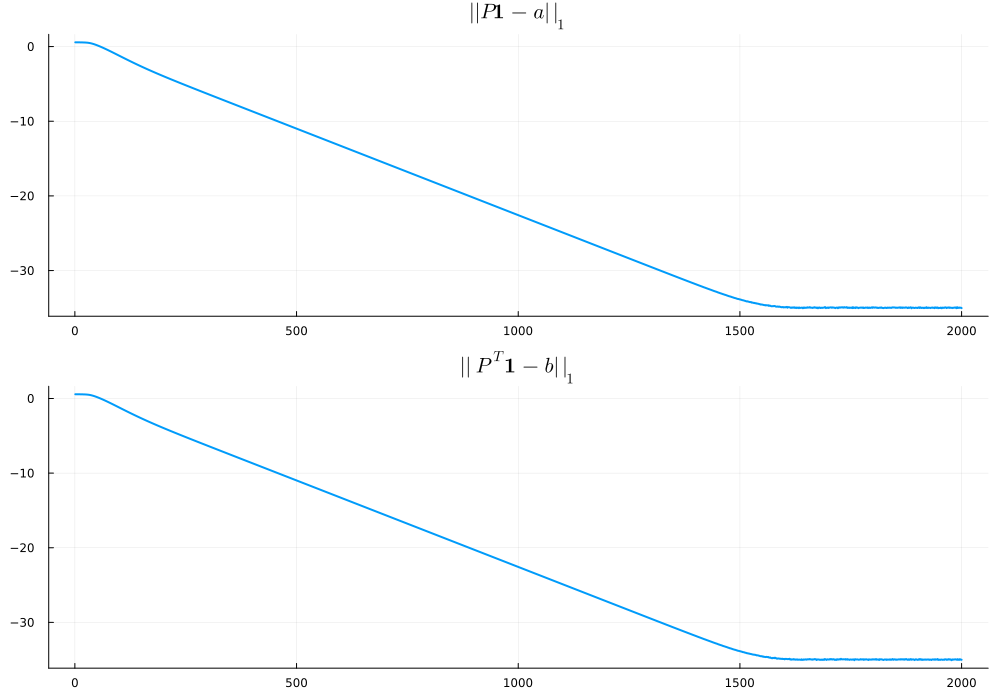

In [33]:
plt, u, v = compute_sinkhorn(N, 2000, K, a, b)
display(plt)

Display the coupling. Use a log domain plot to better vizualize it.

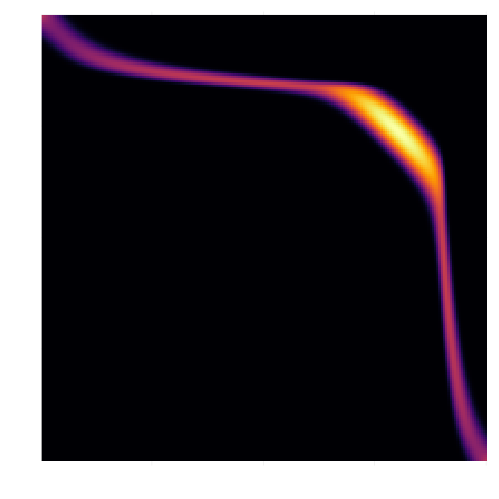

In [34]:
P = diagm(u) * K * diagm(v)
plt = plot(size=(500,500))
imshow!(plt, log.(P .+ 1e-5))
display(plt)

One can approximate the transport map between the two measures using the so-called **barycentric projection**. For each source point indexed by $i$, this projection is defined as:
$$
s_i := \frac{\sum_{j} P_{i,j} \, t_j}{\sum_{j} P_{i,j}}
= \frac{\left[ u \odot \left( K (v \odot t) \right) \right]_i}{a_i},
$$
where:
- $t_j \in [0,1]$ is the target value associated with index $j$,
- $\odot$ denotes element-wise (Hadamard) multiplication,
- $\frac{\cdot}{\cdot}$ denotes element-wise division.

This computation avoids explicitly constructing the full transport matrix $P$ and instead relies on efficient kernel-vector operations involving $K$, $u$, and $v$.

In [35]:
s = (K * (v .* t)) .* u ./ a;

Display the transport map, super-imposed over the coupling.

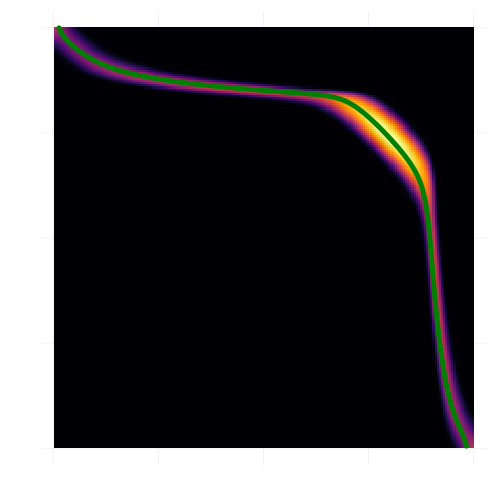

In [36]:
plot!(plt, s * N, t * N, linewidth=5, color=:green, label=nothing)

As a bonus, one can explore the effect of varying the regularization strength $\epsilon$ on the barycentric projection and the resulting transport plan.

Try computing and visualizing the transport map for different values of $\epsilon$. Observe how:

- Larger $\epsilon$ produces smoother, more diffused transport plans.
- Smaller $\epsilon$ results in more sharply concentrated transport, approximating the unregularized optimal transport solution.

This experiment helps illustrate the trade-off between accuracy and numerical stability in entropic regularized optimal transport.

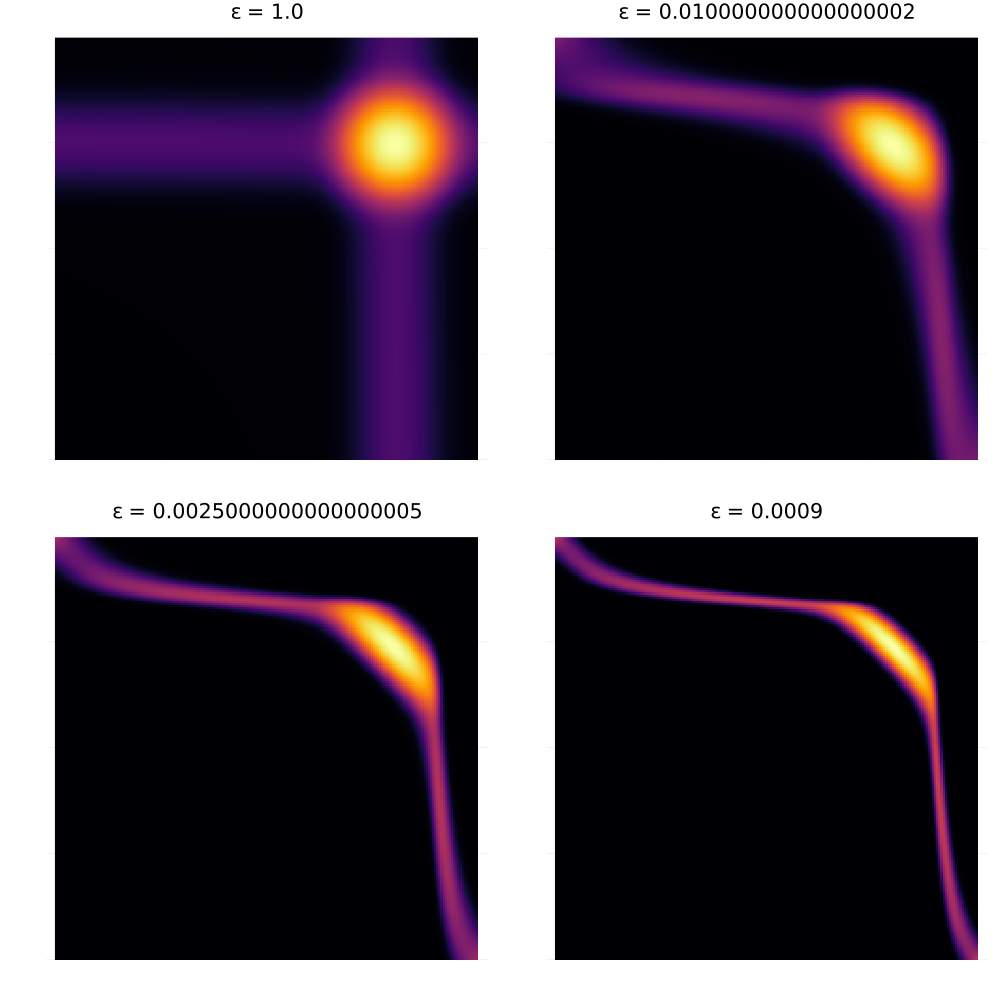

In [37]:
plt = plot(layout=(2, 2), size=(1000, 1000))
eps_list = [1, 0.1, 0.05, 0.03].^2
niter = 300

for (k, epsilon) in enumerate(eps_list)
    K = exp.(-(X - Y).^2 ./ epsilon);
    _, u, v = compute_sinkhorn(N, niter, K, a, b)
    P = diagm(u) * K * diagm(v)
    s = (K * (v .* t)) .* u ./ a
    imshow!(plt[k], log.(P .+ 1e-5), "\\epsilon = $(epsilon)")
end

plot!(plt, axis=false)
display(plt)

Using GPUs
-----------------------

We will use [KernelAbstrations.jl](https://github.com/JuliaGPU/KernelAbstractions.jl) to implement the Sinkhorn algorithm on the GPU.

If you are running the code on **Google Colab**, make sure to enable GPU support:

1. Go to the menu: `Runtime` → `Change runtime type`.
2. Under `Hardware accelerator`, select `GPU`.
3. Click `Save`.

This ensures that tensor operations, especially matrix multiplications and kernel evaluations, are efficiently executed on the GPU.

In [38]:
using Pkg; Pkg.add(["KernelAbstractions", "CUDA"])

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed KernelAbstractions ─ v0.9.37
    Updating `~/.julia/environments/v1.10/Project.toml`
  [63c18a36] + KernelAbstractions v0.9.37
    Updating `~/.julia/environments/v1.10/Manifest.toml`
  [63c18a36] ↑ KernelAbstractions v0.9.36 ⇒ v0.9.37
Precompiling packages...
   3571.3 ms  ✓ KernelAbstractions
    751.1 ms  ✓ KernelAbstractions → LinearAlgebraExt
    839.8 ms  ✓ StructArrays → StructArraysGPUArraysCoreExt
    860.4 ms  ✓ KernelAbstractions → EnzymeExt
   1002.5 ms  ✓ KernelAbstractions → SparseArraysExt
   3167.7 ms  ✓ GPUArrays
   1629.3 ms  ✓ MLDataDevices → MLDataDevicesGPUArraysExt
   1385.0 ms  ✓ WeightInitializers → WeightInitializersGPUArraysExt
   5169.1 ms  ✓ NNlib
   6304.8 ms  ✓ Reactant → ReactantKernelAbstractionsExt
   1277.6 ms  ✓ NNlib → NNlibSpecialFunctionsExt
   1366.0 ms  ✓ NNlib → NNlibEnzymeCoreExt
   1412.3 ms  ✓ NNlib → NNlibFFTWExt
   1317.5 ms  ✓ NNlib → 

In [39]:
import KernelAbstractions as KA
using CUDA

const backend = CUDA.functional() ? CUDABackend() : KA.CPU()

CUDABackend(false, false)

Since CUDA uses float number on 32 bits, one needs to use a quite large value for $\epsilon$ to avoid overflow.

In [40]:
epsilon = (.06)^2
K = exp.(-(X - Y).^2 ./ epsilon);

Convert Sinkohrn variables and host them on GPU (if available).

In [41]:
u = KA.ones(backend, Float32, N)
v = KA.ones(backend, Float32, N)
K1 = KA.adapt(backend, K)
a1 = KA.adapt(backend, a)
b1 = KA.adapt(backend, b);

One sinkhorn's loop.

In [42]:
u = a1 ./ (K1 * v)
v = b1 ./ (K1' * u);

We now implement the full algorithm.

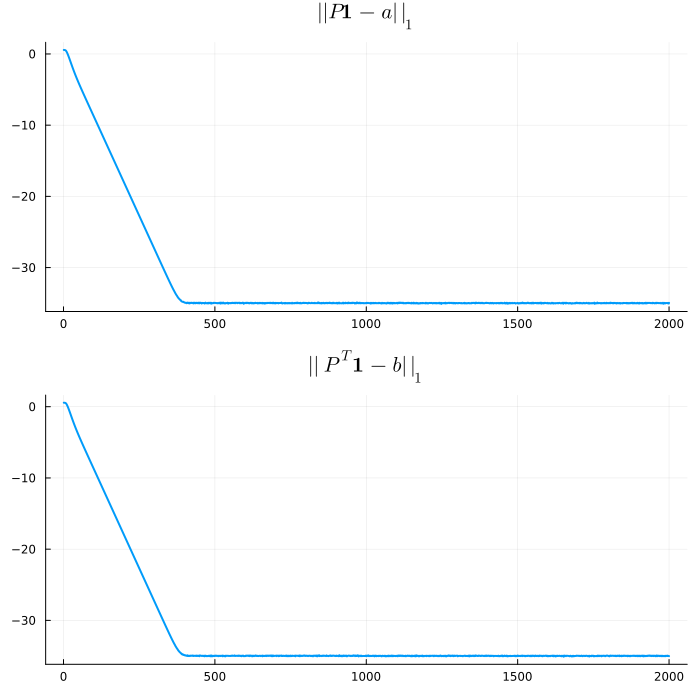

In [43]:
niter = 2000
Err_p_ka = KA.zeros(backend, Float32, 0)
Err_q_ka = KA.zeros(backend, Float32, 0)

for _ in 1:niter
    # Sinkhorn step 1
    u = a1 ./ (K1 * v)

    # Error computation for second marginal
    r = v .* (K1' * u)
    push!(Err_q_ka, norm(r - b1, 1))

    # Sinkhorn step 2
    v = b1 ./ (K1' * u)

    # Error computation for first marginal
    s = u .* (K1 * v)
    push!(Err_p_ka, norm(s - a1, 1))
end

# Convert back to CPU memory
Err_p = Array(Err_p_ka)
Err_q = Array(Err_q_ka)

# Plotting the convergence
plt = plot(layout=(2, 1), size=(700, 700))
plot!(plt[1], log.(Err_p), linewidth=2, title="\$||P \\mathbf{1} - a||_1\$", label=nothing)
plot!(plt[2], log.(Err_q), linewidth=2, title="\$||P^T \\mathbf{1} - b||_1\$", label=nothing)

display(plt)

Wasserstein Barycenters
-----------------------

Instead of computing a transport plan between two measures, we now turn to the problem of computing the **barycenter** of a collection of $R$ input measures $(a_k)_{k=1}^R$.

A barycenter $b$ is defined as a minimizer of the following objective:
$$
\min_{b} \sum_{k=1}^R \lambda_k \, W_\gamma(a_k, b),
$$
where:
- $W_\gamma(a_k, b)$ denotes the entropic regularized transport cost between $a_k$ and $b$,
- $\lambda_k > 0$ are positive weights satisfying $\sum_{k=1}^R \lambda_k = 1$.

This formulation follows the definition of Wasserstein barycenters proposed by Agueh and Carlier (2011).

Dimension (width of the images) $N$ of the histograms.

In [44]:
N = 70

70

You need to install some image processing packages such as ImageIO.

In [ ]:
using Pkg; Pkg.add(["ImageIO", "FileIO", "ImageMagick", "ImageCore"])

In [45]:
using ImageIO
using FileIO
using ImageCore

   Resolving package versions...
   Installed ImageMagick ──────── v1.4.2
   Installed ImageMagick_jll ──── v7.1.1048+0
   Installed GR_jll ───────────── v0.73.7+0
   Installed Libtiff_jll ──────── v4.5.1+1
   Installed LERC_jll ─────────── v3.0.0+1
   Installed Enzyme_jll ───────── v0.0.185+0
   Installed LuxLib ───────────── v1.10.0
   Installed Enzyme ───────────── v0.13.59
   Installed GR ───────────────── v0.73.7
   Installed Qt6Wayland_jll ───── v6.7.1+1
   Installed Qt6Declarative_jll ─ v6.7.1+2
   Installed OpenJpeg_jll ─────── v2.5.4+0
   Installed Qt6ShaderTools_jll ─ v6.7.1+1
   Installed LittleCMS_jll ────── v2.16.0+0
   Installed Qt6Base_jll ──────── v6.7.1+1
   Installed libwebp_jll ──────── v1.4.0+0
   Installed Ghostscript_jll ──── v9.55.0+4
    Updating `~/.julia/environments/v1.10/Project.toml`
  [5789e2e9] + FileIO v1.17.0
  [a09fc81d] + ImageCore v0.10.5
  [82e4d734] + ImageIO v0.6.9
  [6218d12a] + ImageMagick v1.4.2
    Updating `~/.julia/environments/v1.10/Manifes

Load input histograms $(a_k)_{k=1}^R$, store them in a tensor $A$.

In [46]:
# local url
base_path = "nt_toolbox/data/"
# global url
base_path = "https://raw.githubusercontent.com/gpeyre/ot4ml/refs/heads/main/python/data/"

rescale(x) = (x .- minimum(x)) ./ (maximum(x) - minimum(x))
names = ["disk", "twodisks", "letter-x", "letter-z"]
vmin = 0.01
R = length(names)
A = zeros(Float64, N, N, length(names))

for i in 1:length(names)
    a = FileIO.load(download(base_path * names[i] * ".bmp")) .|> Gray
    a = mynormalize(rescale(a) .+ vmin)
    A[:, :, i] = a
end

[ Info: Precompiling ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1]
┌ Warning: Module Libtiff_jll with build ID fafbfcfd-7905-a6e0-0000-00ccd2c9b114 is missing from the cache.
│ This may mean Libtiff_jll [89763e89-9b03-5906-acba-b20f662cd828] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2018
[ Info: Skipping precompilation since __precompile__(false). Importing ImageMagick [6218d12a-5da1-5696-b52f-db25d2ecc6d1].
[ Info: Precompiling ImageMagick_jll [c73af94c-d91f-53ed-93a7-00f77d67a9d7]
┌ Warning: Module Libtiff_jll with build ID fafbfcfd-7905-a6e0-0000-00ccd2c9b114 is missing from the cache.
│ This may mean Libtiff_jll [89763e89-9b03-5906-acba-b20f662cd828] does not support precompilation but is imported by a module that does.
└ @ Base loading.jl:2018
[ Info: Skipping precompilation since __precompile__(false). Importing ImageMagick_jll [c73af94c-d91f-53ed-93a7-00f77d67a9d7].
[ Info: Precompiling OpenJpeg_jll [643b3616-a352-519d-856d-8

Display the input histograms.

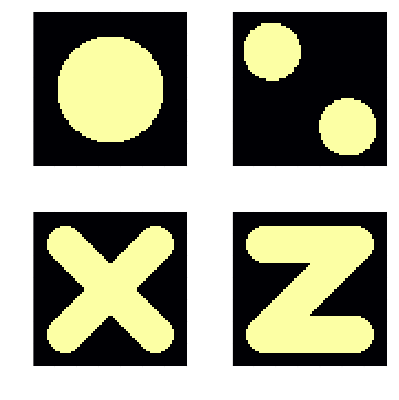

In [47]:
plt = plot(layout=(2, 2), size=(400, 400))

for i in 1:R
    histogram = A[:, :, i]
    imshow!(plt[i], histogram)
end
plot!(plt, axis=false)
display(plt)

In this specific case, the kernel $K$ associated with the squared Euclidean cost corresponds to a convolution with a Gaussian filter:
$$
K_{i,j} = \exp\left( -\frac{\|i/N - j/N\|^2}{\epsilon} \right),
$$
where $(i, j)$ are 2-D spatial indices (e.g., pixel coordinates), and $N$ is the image resolution.

The multiplication of this kernel against a distribution $a$, i.e., computing $K(a)$, can be performed efficiently using **fast convolution methods** such as FFT-based or separable Gaussian filters.

This crucial observation was exploited and generalized in [Solomon et al.](#biblio) to develop fast optimal transport algorithms, particularly in the context of images and grids.

Regularization strength $\epsilon>0$.

In [48]:
epsilon = (.04)^2;

Define the $K$ kernel.
We use here the fact that the convolution is separable to implement it
using only 1-D convolution, which further speeds up computations.

In [49]:
t = (0:N-1)/N;
X = repeat(t, 1, length(t))
Y = repeat(t', length(t), 1)
K1 = exp.(-(X - Y).^2 ./ epsilon)
K_kernel(x) = K1 * x * K1;

Display the application of the $K$ kernel on one of the input histogram.

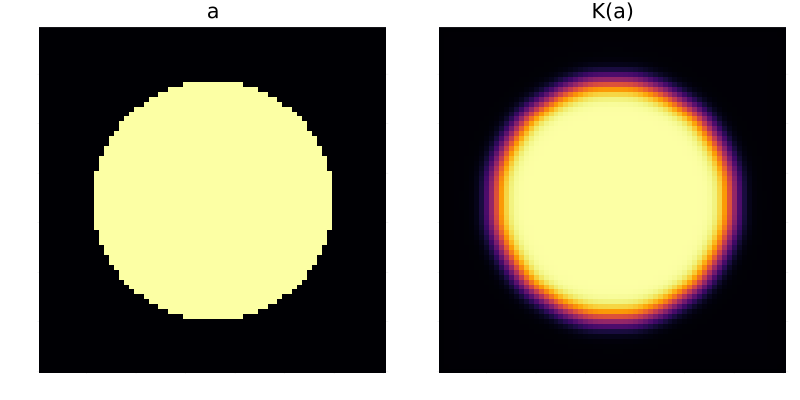

In [50]:
plt = plot(layout=(1, 2), size=(800, 400))
imshow!(plt[1], A[:,:,1], "a",)
imshow!(plt[2], K_kernel(A[:,:,1]), "K(a)",)
display(plt)

Weights $\lambda_k$ for isobarycenter.

In [51]:
lambd = ones(R) ./ R;

It is shown in *Benamou et al.* that the problem of Wasserstein barycenter computation can be reformulated as an optimization problem over a collection of couplings $(P_k)_{k=1}^R$, one for each input measure $a_k$.

This problem can be efficiently solved using an iterative **Sinkhorn-like algorithm**, because each optimal coupling $P_k$ admits a specific scaling form:
$$
P_k = \operatorname{diag}(u_k) \, K \, \operatorname{diag}(v_k),
$$
for some unknown positive scaling vectors $(u_k, v_k)$.

These couplings are subject to marginal constraints, and the barycenter $b$ appears implicitly through these constraints. The iterative algorithm alternates between updating the scaling factors $(u_k, v_k)$ and the barycenter estimate.

Initialize the scaling factors $(u_k,v_k)_k$, store them in matrices.

In [52]:
v = ones(N,N,R)
u = copy(v);

The first step of the **Bregman projection method** corresponds to projecting each coupling $P^k$ onto the constraint that it matches the fixed source marginal:
$$
P^k \mathbf{1} = a_k.
$$

This is achieved by updating the scaling vectors $u_k$ as follows:
$$
\forall k = 1, \ldots, R, \quad u_k \leftarrow \frac{a_k}{K(v_k)},
$$
where the division is element-wise, and $K(v_k)$ denotes the matrix-vector product of the kernel $K$ with the vector $v_k$.

In [53]:
for k in 1:R
    u[:, :, k] .= A[:,:,k] ./ K_kernel(v[:,:,k])
end

The second step of the **Bregman projection method** corresponds to projecting each coupling $P_k$ onto the constraint that they all share a common **barycenter** target marginal:
$$
\forall k, \quad P_k^\top \mathbf{1} = b.
$$

This is achieved by first computing the updated barycenter $b$ using a **geometric mean** of the current marginals:
$$
\log(b) := \sum_k \lambda_k \log\left( u_k \odot K(v_k) \right),
$$
where:
- $\lambda_k$ are positive weights summing to 1,
- $\odot$ denotes element-wise multiplication,
- the logarithm and exponential are applied element-wise.

This step ensures that all transport plans $P_k$ are projected onto a common right marginal while maintaining the entropic regularization structure.

In [54]:
b = zeros(N,N)
for k in 1:R
    b .+= lambd[k] .* log.(max.(1e-19, v[:,:,k] .* K_kernel(u[:,:,k])))
end
b .= exp.(b);

Display $b$.

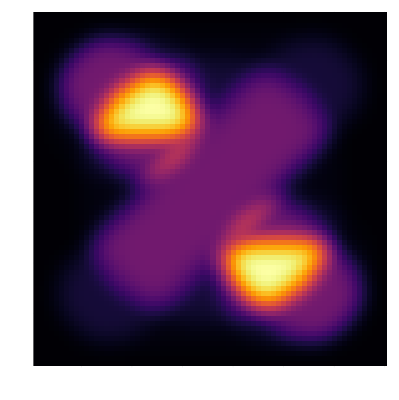

In [55]:
plt = plot(size=(400, 400))
imshow!(plt, b)

After computing the updated barycenter $b$, one can perform the second Sinkhorn update step to adjust the scaling vectors $v_k$ accordingly.

This is done using the newly computed histogram $b$ as follows (note that here the kernel is symmetric, i.e., $K = K^\top$):
$$
\forall k = 1, \ldots, R, \quad v_k \leftarrow \frac{b}{K(u_k)},
$$
where the division is element-wise.

Together with the previous update of $u_k$, this completes one full iteration of the Bregman projection algorithm for Wasserstein barycenter computation under entropic regularization.

In [56]:
for k in 1:R
    v[:,:,k] .= b ./ K_kernel(u[:,:,k])
end

We now implement the iterative algorithm to compute the **iso-barycenter** of the input measures using the Bregman projection (Sinkhorn-like) method.

At each iteration, we monitor the convergence of the algorithm by tracking the violation of the marginal constraints on the source distributions. Specifically, we plot the decay of the following error:
$$
\sum_k \left\| P_k \mathbf{1} - a_k \right\|_1,
$$
where each $P_k = \operatorname{diag}(u_k) \, K \, \operatorname{diag}(v_k)$ is the current coupling for input measure $a_k$.

This error should decrease as the algorithm iterates, reflecting improved satisfaction of the marginal constraints. We display its evolution on a **logarithmic scale** to highlight convergence behavior.

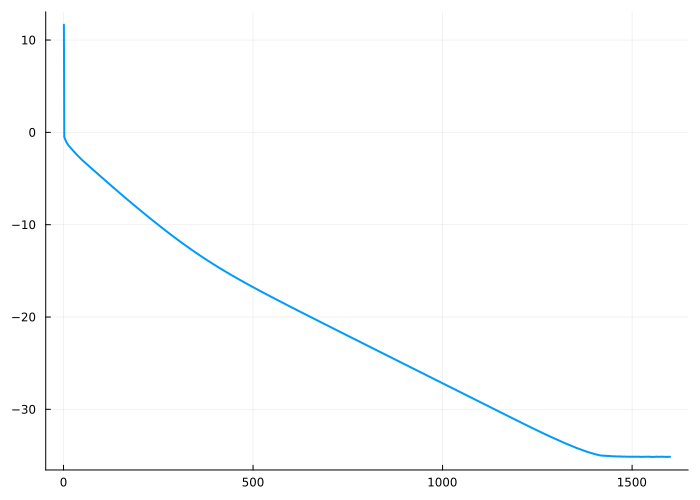

In [57]:
niter = 1600
v = ones(N,N,R)
u = copy(v);
Err_q = zeros(niter)
b = zeros(N,N)

for i in 1:niter
    for k in 1:R
        Err_q[i] = norm(u[:,:,k] .* K_kernel(v[:,:,k]) - A[:,:,k], 1)
        u[:,:,k] = A[:,:,k] ./ K_kernel(v[:,:,k])
    end

    b .= 0
    for k in 1:R
        b .+= lambd[k] .* log.(max.(1e-19, v[:,:,k] .* K_kernel(u[:,:,k])))
    end

    b .= exp.(b)
    for k in 1:R
        v[:,:,k] .= b ./ K_kernel(u[:,:,k])
    end
end

plt = plot(size=(700, 500))
plot!(plt, log.(Err_q), linewidth=2, label=nothing)

Display the barycenter.

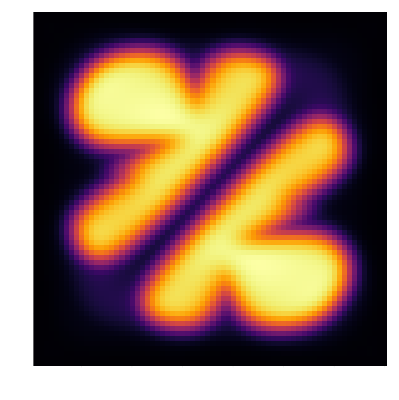

In [58]:
plt = plot(size=(400, 400))
imshow!(plt, b)

We now compute Wasserstein barycenters for varying weight vectors $\lambda$, corresponding to a **bilinear interpolation** inside a square.

This means we generate a family of weights $\lambda = (\lambda_1, \lambda_2, \lambda_3, \lambda_4)$ such that:
- Each $\lambda_k \geq 0$,
- $\sum_{k=1}^4 \lambda_k = 1$,
- The weights vary smoothly over a 2D grid (e.g., over coordinates $(x, y) \in [0,1]^2$),
- The corners of the square correspond to the four input measures.

This setup allows us to visualize how the barycenter changes continuously as we interpolate between the input measures in the Wasserstein space.

 24.584386 seconds (4.40 M allocations: 40.309 GiB, 2.82% gc time)


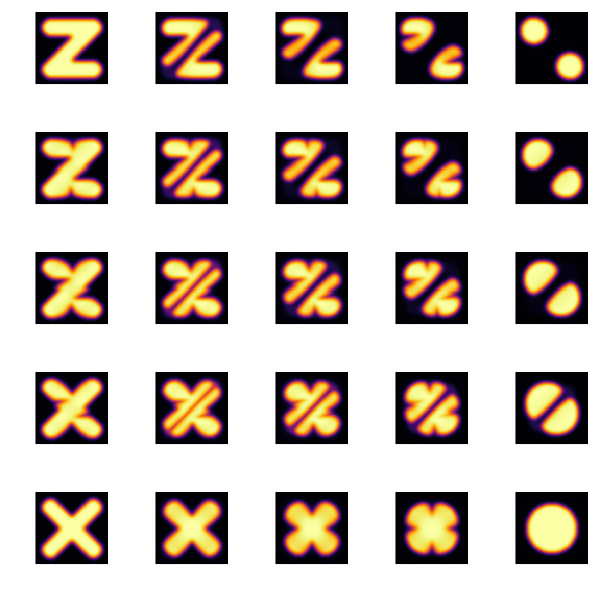

In [65]:
m = 5
weights = (0:(m-1)) ./ (m-1)
niter = 1000
plt = plot(layout=(m, m), size=(600, 600))
i = 1
v = ones(N,N,R)
u = similar(v)
b = zeros(N,N)

@time for S in weights, T in weights
    lambd = [S*T, (1 - S)*T, S*(1 - T), (1 - S)*(1 - T)]

    v .= 1
    u .= 1

    for _ in 1:niter
        for k in 1:R
            u[:,:,k] .= A[:,:,k] ./ K_kernel(v[:,:,k])
        end

        b .= 0
        for k in 1:R
            b .+= lambd[k] .* log.(max.(1e-19, v[:,:,k] .* K_kernel(u[:,:,k])))
        end
        b .= exp.(b)

        for k in 1:R
            v[:,:,k] .= b ./ K_kernel(u[:,:,k])
        end
    end

    imshow!(plt[i], b)
    i += 1
end

display(plt)

### Julia-specific speed-ups

In [61]:
# In-place K function using the in-place `mul!` function.
# Use a pre-allocated matrix `K_temp` to store the intermediate result.
# The result is directly written in `K_res`.
# This should result in no allocations.
function K!(K_res, K_temp, x)
    mul!(K_temp, K1, x)
    mul!(K_res, K_temp, K1)
end

K! (generic function with 1 method)

 18.523496 seconds (267.15 k allocations: 18.069 MiB, 3.66% compilation time)


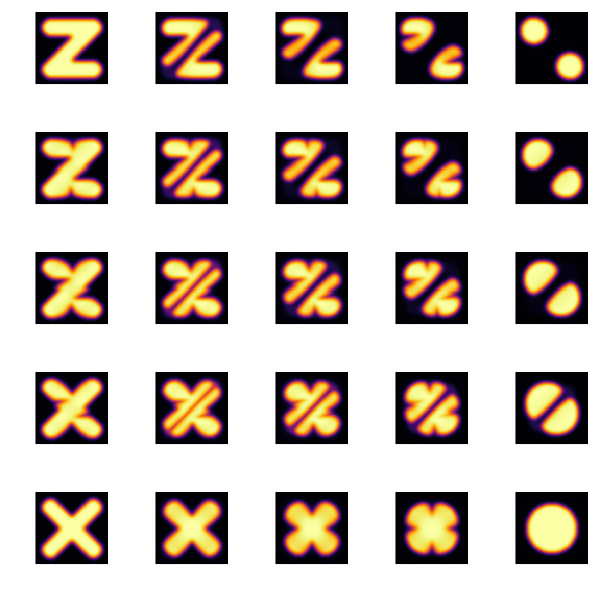

In [64]:
m = 5
weights = (0:(m-1)) ./ (m-1)
niter = 1000

# Pre-allocate data structures that are re-used multiple times
b = zeros(N,N)
v = [ones(N,N) for _ in 1:R]
u = [ones(N,N) for _ in 1:R]
Ku = similar(b)
Kv = similar(b)
K_temp = similar(b)

# Save the different `b` values for display in `bs`
bs = [ones(N,N) for _ in 1:(m*m)]

# Encapsulating core computation inside a function is good practice in Julia.
function wasserstein_computation!(b, lambd, u, v, A, R, Ku, Kv, K_temp, niter)

    # Reset values of `u` and `v`
    for k in 1:R
        u[k] .= 1
        v[k] .= 1
    end

    for _ in 1:niter
        for k in 1:R
            K!(Kv, K_temp, v[k])
            u[k] .= @view(A[:,:,k]) ./ Kv
        end

        b .= 0
        for k in 1:R
            K!(Ku, K_temp, u[k])
            b .+= lambd[k] .* log.(max.(1e-19, v[k] .* Ku))
        end

        b .= exp.(b)
        for k in 1:R
            K!(Ku, K_temp, u[k])
            v[k] .= b ./ Ku
        end
    end
end

i = 1
@time for S in weights, T in weights
    lambd = [S*T, (1 - S)*T, S*(1 - T), (1 - S)*(1 - T)]
    wasserstein_computation!(b, lambd, u, v, A, R, Ku, Kv, K_temp, niter)
    bs[i] .= b
    i += 1
end

plt = plot(layout=(m, m), size=(600, 600))

for i in 1:(m*m)
    imshow!(plt[i], bs[i])
end

display(plt)

## Bibliography
<a name="biblio"></a>

- **[Villani]** C. Villani (2009). *Optimal Transport: Old and New*, Volume 338. Springer Verlag.

- **[Cuturi]** M. Cuturi (2013). Sinkhorn Distances: Lightspeed Computation of Optimal Transport. In *Advances in Neural Information Processing Systems (NIPS)*, pp. 2292–2300.

- **[AguehCarlier]** M. Agueh and G. Carlier (2011). Barycenters in the Wasserstein Space. *SIAM Journal on Mathematical Analysis*, 43(2):904–924.

- **[CuturiDoucet]** M. Cuturi and A. Doucet (2014). Fast Computation of Wasserstein Barycenters. In *Proceedings of the International Conference on Machine Learning (ICML)*.

- **[BauschkeLewis]** H. H. Bauschke and A. S. Lewis (2000). Dykstra's Algorithm with Bregman Projections: A Convergence Proof. *Optimization*, 48(4):409–427.

- **[Sinkhorn]** R. Sinkhorn (1964). A Relationship Between Arbitrary Positive Matrices and Doubly Stochastic Matrices. *Annals of Mathematical Statistics*, 35:876–879.

- **[SolomonEtAl]** J. Solomon, F. de Goes, G. Peyré, M. Cuturi, A. Butscher, A. Nguyen, T. Du, and L. Guibas (2015). Convolutional Wasserstein Distances: Efficient Optimal Transportation on Geometric Domains. *Transactions on Graphics*, Proc. SIGGRAPH.

- **[BenamouEtAl]** J.-D. Benamou, G. Carlier, M. Cuturi, L. Nenna, and G. Peyré (2015). Iterative Bregman Projections for Regularized Transportation Problems. *SIAM Journal on Scientific Computing*, 37(2):A1111–A1138.